In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import datetime
import matplotlib.pyplot as plt
import requests
import json
import joblib
from tvDatafeed import TvDatafeed, Interval

In [5]:
def tune_alpha(x_train,x_validate,y_train,y_validate):
    alp =np.logspace(-4, 4, 1000).tolist()
    column_names = ["alpha", "RMSE","MAE"]
    data =[]
    for i in alp:
        model = Ridge(alpha=i)
        model.fit(x_train, y_train)
        y_validate_predict = model.predict(x_validate)
        rmse=mean_squared_error(y_validate, y_validate_predict, squared=False)
        mae=mean_absolute_error(y_validate, y_validate_predict)
        data.append([i,rmse,mae])
    df = pd.DataFrame(data, columns=column_names)    
    return df

In [7]:
bitcoin = pd.read_pickle("../data/cleaned/bitcoin_value_2020-now_cleaned.pkl")
required_features = ['open_bitcoin','open_eth','open_bnb','open_ada','value_number_transaction','value_number_address','value_transaction_second','value_total_bitcoin','value_hash_rate']
output_label = ['close_bitcoin']
x_set=bitcoin[required_features].copy()
y_set=bitcoin[output_label].copy()

In [8]:
corr = x_set.corr()

<AxesSubplot:>

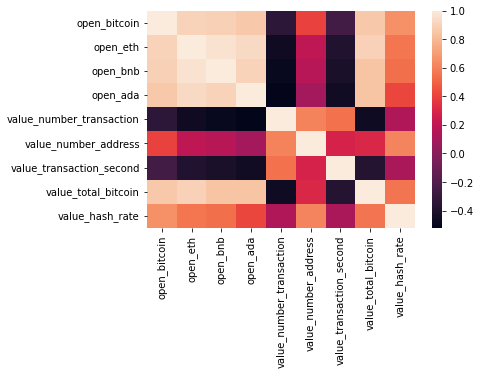

In [9]:
sns.heatmap(corr)

In [10]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
selected_columns = x_set.columns[columns]
x_set = x_set[selected_columns]

In [11]:
selected_features = selected_columns

In [12]:
selected_features

Index(['open_bitcoin', 'open_eth', 'open_ada', 'value_number_transaction',
       'value_number_address', 'value_transaction_second',
       'value_total_bitcoin', 'value_hash_rate'],
      dtype='object')

In [13]:
num_train=int(0.7*len(x_set))
num_valid=int(0.85*len(x_set))
x_train = x_set[0:num_train].copy()
x_validate = x_set[num_train:num_valid].copy()
x_test = x_set[num_valid:(len(x_set)-1)].copy()

scaler = StandardScaler().fit(x_train)
x_train[selected_features] = scaler.transform(x_train[selected_features]).copy()
x_validate[selected_features] = scaler.transform(x_validate[selected_features]).copy()
x_test[selected_features] = scaler.transform(x_test[selected_features]).copy()

y_train = y_set[0:num_train].copy()
y_validate = y_set[num_train:num_valid].copy()
y_test = y_set[num_valid:(len(y_set)-1)].copy()

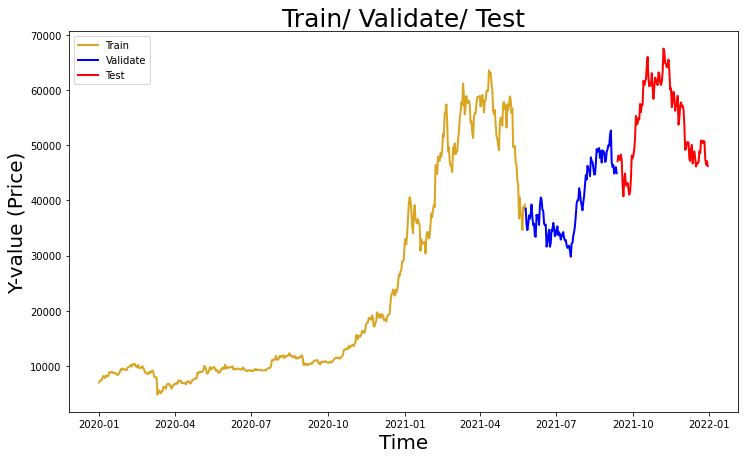

In [14]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"][0:num_train], y_train["close_bitcoin"], color='goldenrod', lw=2)
plt.plot(bitcoin["datetime"][num_train:num_valid], y_validate["close_bitcoin"], color='blue', lw=2)
plt.plot(bitcoin["datetime"][num_valid:(len(y_set)-1)], y_test["close_bitcoin"], color='red', lw=2)
plt.title("Train/ Validate/ Test", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Y-value (Price)", size=20)
plt.legend(['Train', 'Validate', 'Test'])
plt.show()

In [15]:
df=tune_alpha(x_train,x_validate,y_train,y_validate)
tuned_alpha=df[df.RMSE == df.RMSE.min()].alpha.values[0]
tuned_alpha2=df[df.MAE == df.MAE.min()].alpha.values[0]
tuned_alpha

4.174655289253135

In [16]:
model = Ridge(alpha=tuned_alpha)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [17]:
d={'Feature':x_train.columns,'Coefficients':model.coef_[0]}

In [18]:
df = pd.DataFrame(d)   
df

,Feature,Coefficients
0,open_bitcoin,16792.532632
1,open_eth,-208.001745
2,open_ada,454.307704
3,value_number_transaction,-446.241873
4,value_number_address,784.965942
5,value_transaction_second,20.674383
6,value_total_bitcoin,-182.659871
7,value_hash_rate,361.605908


In [19]:
print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred,squared=False))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

Root Mean Squared Error: 2029.0167002611547
Mean Absolute Error: 1642.8154908832867
R2 score: 0.9189334466101032


In [20]:
y_result = y_test.copy()
temp = y_pred.tolist()
y_result["close_bitcoin_pred"] = [np_float[0] for np_float in temp]
y_result.rename(columns={"close_bitcoin":"close_bitcoin_true"},inplace=True)
temp2 = bitcoin["datetime"].copy()
y_result = pd.merge(y_result, temp2, left_index=True, right_index=True)
y_result.tail()

,close_bitcoin_true,close_bitcoin_pred,datetime
725,50701.44,50236.332547,2021-12-26
726,47543.74,50174.154235,2021-12-27
727,46464.66,47358.594427,2021-12-28
728,47120.87,45771.997158,2021-12-29
729,46216.93,46823.912110,2021-12-30


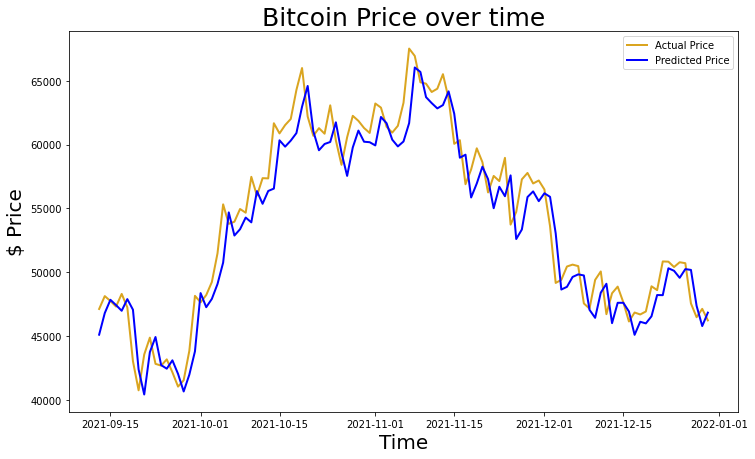

In [21]:
plt.figure(figsize = (12, 7))
plt.plot(y_result["datetime"], y_result["close_bitcoin_true"], color='goldenrod', lw=2)
plt.plot(y_result["datetime"], y_result["close_bitcoin_pred"], color='blue', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

In [22]:
joblib.dump(model, 'savedmodel_no_sentiment.pkl')
joblib.dump(scaler, 'savedscaler_no_sentiment.pkl')

model_from_joblib = joblib.load('savedmodel_no_sentiment.pkl')
scaler_from_joblib = joblib.load('savedscaler_no_sentiment.pkl')

model_from_joblib.predict(x_test)[-1]


array([46823.91211016])

In [23]:
y_pred[-1]

array([46823.91211016])